# Preliminary operations

In [ ]:
#@title Drive mount

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Assignment/OriginalDataset

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Assignment/OriginalDataset


In [ ]:
#@title Main libraries
import pandas as pd
import numpy as np
import csv
import pickle

import os
import random

from sklearn.utils import  compute_class_weight

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
#@title Reproducibility
# Setting a seed for reproducibility
seed = 90 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("The seed is: " + str(seed))

The seed is: 90


In [ ]:
test_set = ImageDataGenerator().flow_from_directory(directory = "test_merged",
                                                    class_mode = None,
                                                    batch_size = 128,
                                                    shuffle = False,
                                                    seed = seed)

Found 3093 images belonging to 1 classes.


# Model predictions


In [ ]:
ensemble = { 'name': 'Ensemble',
        'predictions': np.load('/content/gdrive/MyDrive/AI project/models/final_predictions_Ensemble.npy')}

In [ ]:
target = np.load('/content/gdrive/MyDrive/AI project/models/target_ensemble.npy')

In [ ]:
legend = {'Normal': 0, 'Pneumonia': 1, 'Tubercolosis': 2}

# Confidence Analysis

In [ ]:
#@title Get results function

def get_results_table(pred, thr, target):
  # Single class prediction (no matter the confidence)
  pred_classes = np.argmax(pred, axis=-1)

  pred_multiclass = (pred > thr)

  results = pd.concat([pd.DataFrame(test_set.filenames, columns=['File']),
                      pd.DataFrame(pred_multiclass, columns=['Normal (bin)', 'Pneumonia (bin)', 'Tubercolosis (bin)']),
                      pd.DataFrame(np.round(pred,3), columns=['Normal', 'Pneumonia', 'Tubercolosis'])], axis=1)

  results['Count'] = np.sum(pred_multiclass, axis=-1)
  results['Predicted class'] = pred_classes
  results['Target class'] = target
  results['Correct prediction'] = (target == pred_classes)
  
  return results

In [274]:
#@title Get plots functions

def BoxPlot_Comparison(corr_prob, not_corr_prob, title):
  """This function creates a boxplot comparing the probability of the correct and not correct images
    Input:
    corr_prob: list of probabilities of the correctly classified images
    not_corr_prob: list of probabilities of the not correctly classified images
    title: title of the plot
  """
  # Create a figure instance
  fig = plt.figure(1, figsize=(10, 5))

  # Create the boxplot
  bp = plt.boxplot([corr_prob, not_corr_prob])

  #plt.title(title, size=14)
  plt.xticks([1, 2], ['Correct', 'Not Correct'], size=14)
  plt.ylabel("Max class probability", size=14)
  plt.show()


def Histogram_Comparison(corr_prob,not_corr_prob, x_bnd=(0.5,1), y_bnd=(0,10), nbins=10, thresh=0):
  """This function plots the histograms of the probabilities of the correctly 
  classified and misclassified images.
  
  Inputs:
  corr_prob: list of probabilities of correctly classified images
  not_corr_prob: list of probabilities of misclassified images
  x_bnd: tuple of the x-axis bounds
  y_bnd: tuple of the y-axis bounds
  nbins: number of bins in the histogram
  thresh: optionally it can superimpose a vertical line on the plot
  """
  plt.figure(figsize=(10,5))
  plt.hist(corr_prob, bins=nbins, alpha=0.5, label="Correctly Classified")
  plt.hist(not_corr_prob, bins=nbins, alpha=0.5, label="Misclassified")

  plt.xlim(x_bnd)
  plt.ylim(y_bnd)

  if(thresh>0):
    plt.axvline(x = thresh, color = 'b', label = 'Threshold')

  plt.xlabel("Classification confidence", size=14)
  plt.ylabel("Count", size=14)
  plt.title("Confidence analysis")
  plt.legend(loc='upper left')

In [ ]:
pred = ensemble['predictions']
print(pred.shape)
print(target.shape)

(3093, 3)
(3093,)


In [260]:
results = get_results_table(pred, 0.8, target)
results

,File,Normal (bin),Pneumonia (bin),Tubercolosis (bin),Normal,Pneumonia,Tubercolosis,Count,Predicted class,Target class,Correct prediction
0,all/P00001_1.png,False,False,False,0.687,0.004,0.309,0,0,0,True
1,all/P00001_2.png,True,False,False,0.983,0.000,0.017,1,0,0,True
2,all/P00003_1.png,True,False,False,1.000,0.000,0.000,1,0,0,True
3,all/P00006_1.png,True,False,False,1.000,0.000,0.000,1,0,0,True
4,all/P00006_2.png,True,False,False,1.000,0.000,0.000,1,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...
3088,all/P16070_1.jpeg,False,False,True,0.000,0.000,1.000,1,2,2,True
3089,all/P16071_1.jpeg,False,False,True,0.016,0.001,0.982,1,2,2,True
3090,all/P16089_1.png,False,False,True,0.000,0.000,1.000,1,2,2,True
3091,all/P16090_1.png,False,False,True,0.000,0.000,1.000,1,2,2,True


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


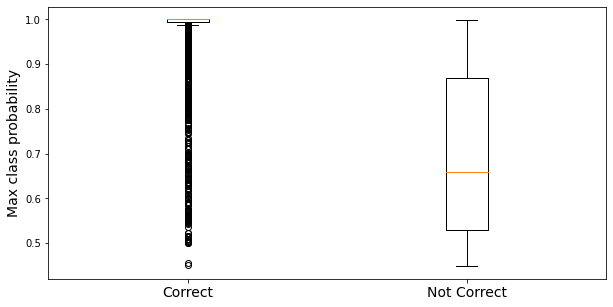

In [275]:
# @title Boxplot
correct_predictions = results[(results['Correct prediction']==True)][['Normal', 'Pneumonia', 'Tubercolosis']]
NOT_correct_predictions = results[(results['Correct prediction']==False)][['Normal', 'Pneumonia', 'Tubercolosis']]

confidence_correct_predictions = correct_predictions.max(axis=1)
confidence_NOT_correct_predictions = NOT_correct_predictions.max(axis=1)

BoxPlot_Comparison(confidence_correct_predictions, confidence_NOT_correct_predictions,"Confidence analysis")

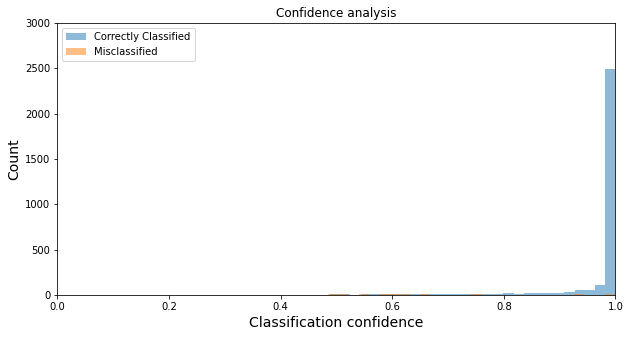

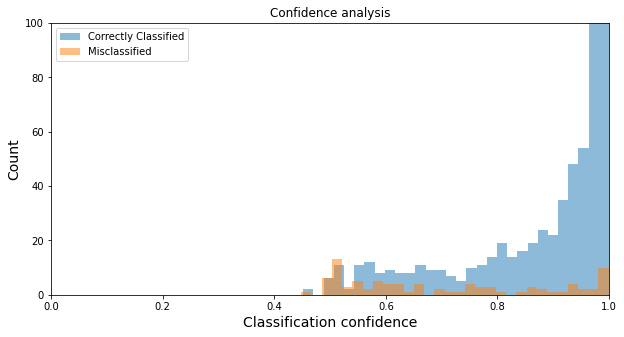

In [270]:
# @title Histogram
Histogram_Comparison(confidence_correct_predictions, confidence_NOT_correct_predictions,x_bnd=(0,1) , y_bnd=(0,3000), nbins=30)
Histogram_Comparison(confidence_correct_predictions, confidence_NOT_correct_predictions,x_bnd=(0,1) , y_bnd=(0,100), nbins=30)

In [ ]:
#@title Cofidence analysis function

def get_confidence_analysis(predictions, target, threshold=0.8, step=0.025, nv=8):
  Table = pd.DataFrame()

  thresholds = np.arange(threshold-(nv*step),threshold+(nv*step), step)
  thresholds_with_start = np.insert(thresholds,0,0.33)

  for thr in thresholds_with_start:
    # Single class prediction (no matter the confidence)
    pred_classes = np.argmax(pred, axis=-1)
    N = len(pred_classes)
    
    # Classes over threshold
    pred_multiclass = (pred > thr)

    pred_provided = pred_classes[np.sum(pred_multiclass, axis=-1)>=1]
    target_pred_provided = target[np.sum(pred_multiclass, axis=-1)>=1]
    pred_not_provided = pred_classes[np.sum(pred_multiclass, axis=-1)<1]
    target_pred_not_provided = target[np.sum(pred_multiclass, axis=-1)<1]

    PP = len(pred_provided)
    NPP = len(pred_not_provided)

    PP_Acc = accuracy_score(target_pred_provided, pred_provided)
    TotAcc= PP_Acc*(PP/N)
    TotErr = (1-PP_Acc)*(PP/N)
    NPP_rate = NPP/N

    n_dec=3

    line = {
      'Threshold': thr,
      'Pred. provided (abs, %)': [PP, np.round(PP/N, n_dec)],
      'Pred. NOT provided (abs, %)': [NPP, np.round(NPP_rate, n_dec)],
      'PP Accuracy': np.round(PP_Acc, n_dec),
      'Total accuracy': np.round(TotAcc,n_dec),
      'Total error': np.round(TotErr, n_dec),
      'PP Precision [N, P, T]': np.round(precision_score(target_pred_provided, pred_provided, average=None), n_dec),
      'PP Recall [N, P, T]': np.round(recall_score(target_pred_provided, pred_provided, average=None), n_dec),
      'NPP (%) [N, P, T]': np.round([ ((target_pred_not_provided==0).sum())/NPP, ((target_pred_not_provided==1).sum())/NPP, ((target_pred_not_provided==2).sum())/NPP], n_dec) }

    Table = Table.append(line, ignore_index=True)

  return Table

In [283]:
def plot_comparison(Table, n= 1, fs=12, figsize=(10, 6)):

  dfC = pd.DataFrame({'Threshold': Table['Threshold'].round(3), 'Total accuracy': Table['Total accuracy'], 'Total error': Table['Total error'], 'Not Prov. Pred. (%)': np.array(Table['Pred. NOT provided (abs, %)'].tolist())[:,1]})
  dfC.plot(kind='barh', stacked=True, x='Threshold', colormap='Paired', figsize=figsize)

  # put numbers on top of the bars
  for i in range(0, len(dfC)):
       threshold = dfC['Threshold'][i]
       total_accuracy = dfC['Total accuracy'][i]
       total_error = dfC['Total error'][i]
       total_not_provided = dfC['Not Prov. Pred. (%)'][i]
       plt.text(total_accuracy/2, i, '{:.2f}%'.format(total_accuracy*100), ha='center', va='center', fontsize=fs, fontweight='bold')
       plt.text(total_accuracy + total_error/2 - 0.022, i, '{:.2f}%'.format(total_error*100), ha='right', va='center', fontsize=fs, fontweight='bold')
       plt.text(1, i+0.43, '{:.2f}%'.format(total_not_provided*100), ha='center', va='center', fontsize=fs,fontweight='bold')

  plt.legend(loc='center left', bbox_to_anchor=(0, 0.1), framealpha=1, fontsize=fs )
  plt.xlabel('Percentage', fontsize=fs)
  plt.ylabel('Threshold', fontsize=fs)
  plt.ylim(-0.3,len(dfC)-0.3)
  plt.title('Total accuracy, Total error and Not Provided Predition Rate', fontsize=fs)
  plt.show()

In [ ]:
Table = get_confidence_analysis(pred, target)

<ipython-input-254-8cf33d14598e>:41: RuntimeWarning: invalid value encountered in long_scalars
  'NPP (%) [N, P, T]': np.round([ ((target_pred_not_provided==0).sum())/NPP, ((target_pred_not_provided==1).sum())/NPP, ((target_pred_not_provided==2).sum())/NPP], n_dec) }


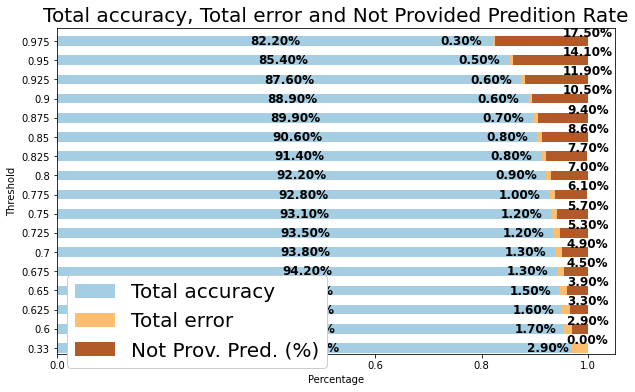

In [ ]:
plot_comparison(Table, figsize=(10, 6))

In [ ]:
Table=get_confidence_analysis(pred,target, threshold=0.75, step=0.05, nv=3)

<ipython-input-254-8cf33d14598e>:41: RuntimeWarning: invalid value encountered in long_scalars
  'NPP (%) [N, P, T]': np.round([ ((target_pred_not_provided==0).sum())/NPP, ((target_pred_not_provided==1).sum())/NPP, ((target_pred_not_provided==2).sum())/NPP], n_dec) }


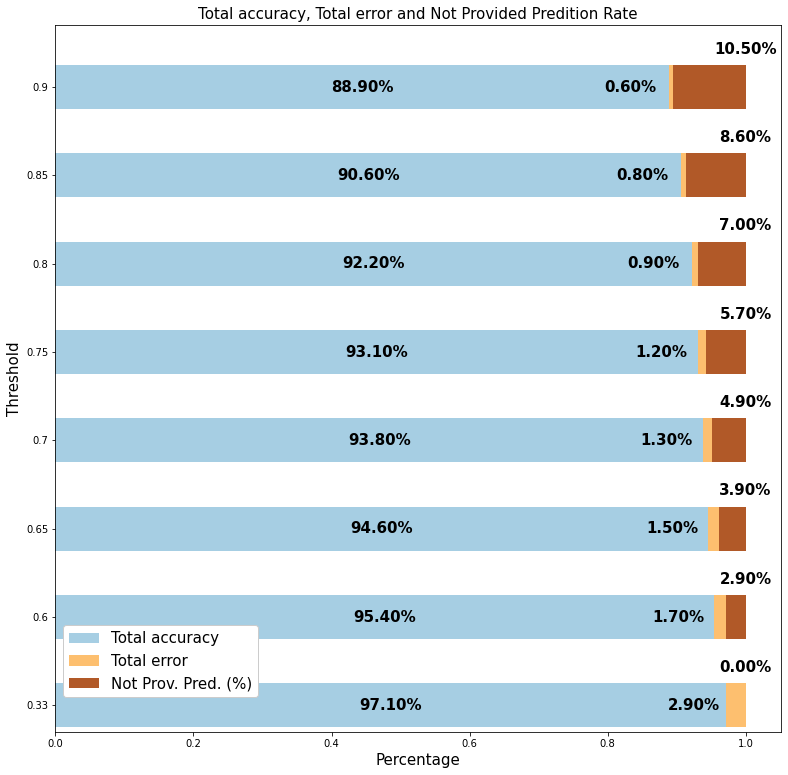

In [288]:
plot_comparison(Table, fs= 15, figsize=(13, 13))